In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import cv2
import os
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [207]:
train_path = '/kaggle/input/smoking/Training/Training'
test_path = '/kaggle/input/smoking/Testing/Testing'
val_path = '/kaggle/input/smoking/Validation/Validation'

In [208]:
def load_and_preprocess_images(file_paths, target_size=(250, 250)):
    images = []
    for file_path in file_paths:
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Zamień format BGR na RGB
        img = cv2.resize(img, target_size)
        img_array = img.astype(np.float32) / 255.0
        images.append(img_array)
    return np.array(images)

X_train = load_and_preprocess_images([os.path.join(train_path, filename) for filename in os.listdir(train_path)])
X_test = load_and_preprocess_images([os.path.join(test_path, filename) for filename in os.listdir(test_path)])
X_val = load_and_preprocess_images([os.path.join(val_path, filename) for filename in os.listdir(val_path)])

In [209]:
single_image = np.array(X_train[0])

print("Single image shape:", single_image.shape)

Single image shape: (250, 250, 3)


In [210]:
def assign_class_from_filename(filename):
    if filename.lower().startswith("smoking"):
        return 1 
    else:
        return 0

y_train = [assign_class_from_filename(filename) for filename in os.listdir('/kaggle/input/smoking/Training/Training/')]

y_test = [assign_class_from_filename(filename) for filename in os.listdir('/kaggle/input/smoking/Testing/Testing/')]

y_val = [assign_class_from_filename(filename) for filename in os.listdir('/kaggle/input/smoking/Validation/Validation/')]

unique_classes = set(y_train + y_test + y_val)
print("Unikalne klasy:", unique_classes)

Unikalne klasy: {0, 1}


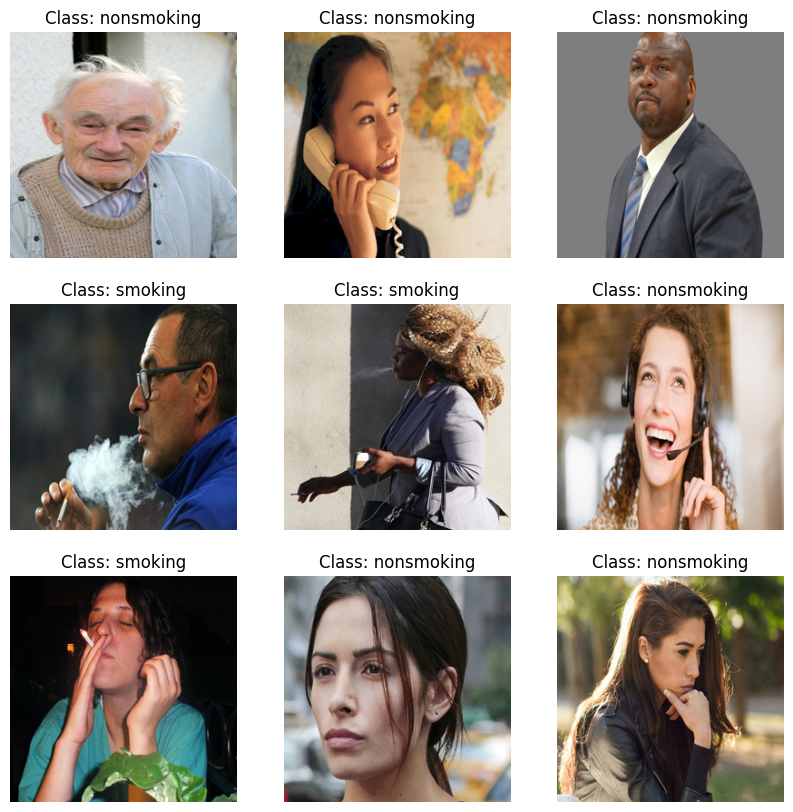

In [211]:
sample_indices = np.random.randint(0, len(X_train), 9)

plt.figure(figsize=(10, 10))
for i, index in enumerate(sample_indices):
    image = X_train[index]
    label = y_train[index]
    class_name = "smoking" if label == 1 else "nonsmoking"
    
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Class: {class_name}")
    plt.axis("off")

plt.show()

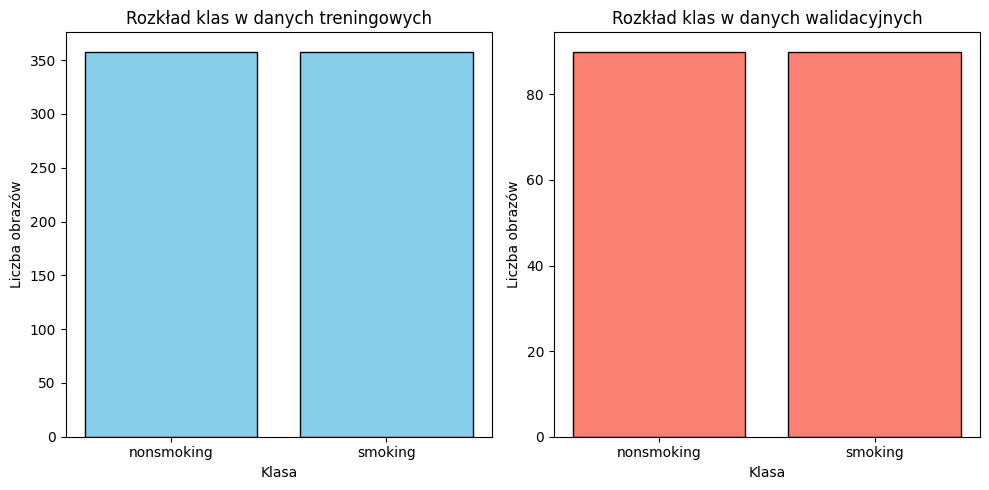

In [212]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(y_train, bins=[-0.5, 0.5, 1.5], edgecolor='black', align='mid', rwidth=0.8, color='skyblue')
plt.xticks([0, 1], ['nonsmoking', 'smoking'])
plt.title('Rozkład klas w danych treningowych')
plt.xlabel('Klasa')
plt.ylabel('Liczba obrazów')

plt.subplot(1, 2, 2)
plt.hist(y_val, bins=[-0.5, 0.5, 1.5], edgecolor='black', align='mid', rwidth=0.8, color='salmon')
plt.xticks([0, 1], ['nonsmoking', 'smoking'])
plt.title('Rozkład klas w danych walidacyjnych')
plt.xlabel('Klasa')
plt.ylabel('Liczba obrazów')

plt.tight_layout()
plt.show()

In [213]:
X_train = np.array(X_train)
y_train_one_hot = to_categorical(y_train, num_classes)
X_val = np.array(X_val)
y_val_one_hot = to_categorical(y_val, num_classes)
X_test = np.array(X_test)
y_test_one_hot = to_categorical(y_test, num_classes)

X_train_original = np.copy(X_train)
y_train_original_one_hot = np.copy(y_train_one_hot)
X_val_original = np.copy(X_val)
X_test_original = np.copy(X_test)

X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [214]:
augmented_indices_train = random.sample(range(len(X_train)), int(len(X_train)))

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.4,
    zoom_range=0.4,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

selected_images_generator_train = (X_train[i] for i in augmented_indices_train)

X_selected_resized_augmented_train = []
num_augmentations = 5  

for img in selected_images_generator_train:
    resized_img = tf.image.resize(img, (250, 250), preserve_aspect_ratio=True).numpy()
    augmented_images = [datagen.random_transform(resized_img) for _ in range(num_augmentations)]
    X_selected_resized_augmented_train.extend(augmented_images)

X_selected_resized_augmented_train = np.array(X_selected_resized_augmented_train)
y_train_augmented_one_hot = np.repeat(y_train_one_hot[augmented_indices_train], num_augmentations, axis=0)

X_train_combined = np.concatenate([X_train_original, X_selected_resized_augmented_train], axis=0)
y_train_combined_one_hot = np.concatenate([y_train_original_one_hot, y_train_augmented_one_hot], axis=0)

print("X_train_original shape:", X_train_original.shape)
print("y_train_original_one_hot shape:", y_train_original_one_hot.shape)
print("X_selected_resized_augmented_train shape:", X_selected_resized_augmented_train.shape)
print("y_train_augmented_one_hot shape:", y_train_augmented_one_hot.shape)
print("X_train_combined shape:", X_train_combined.shape)
print("y_train_combined_one_hot shape:", y_train_combined_one_hot.shape)

X_train_original shape: (716, 250, 250, 3)
y_train_original_one_hot shape: (716, 2)
X_selected_resized_augmented_train shape: (3580, 250, 250, 3)
y_train_augmented_one_hot shape: (3580, 2)
X_train_combined shape: (4296, 250, 250, 3)
y_train_combined_one_hot shape: (4296, 2)


In [217]:
X_train = X_train_combined
y_train = y_train_combined_one_hot
y_val = y_val_one_hot

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train_one_hot shape:", y_train.shape)  # Zaktualizowana etykieta
print("y_val_one_hot shape:", y_val.shape)

X_train shape: (4296, 250, 250, 3)
X_val shape: (180, 250, 250, 3)
y_train_one_hot shape: (4296, 2)
y_val_one_hot shape: (180, 2)


In [220]:
Należy zmienić rozmiar obazów na mniejsze!
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(250, 250, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100
135/135 [==============================] - 20s 61ms/step - loss: 0.7078 - accuracy: 0.4970 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/100
135/135 [==============================] - 7s 53ms/step - loss: 0.6899 - accuracy: 0.5426 - val_loss: 0.6942 - val_accuracy: 0.5000
Epoch 3/100
135/135 [==============================] - 7s 53ms/step - loss: 0.6936 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/100
135/135 [==============================] - 7s 54ms/step - loss: 0.6912 - accuracy: 0.5088 - val_loss: 0.6933 - val_accuracy: 0.5000
